I want to develop two random effect models: Clusters random-effects are independent, and Clusters random-effects are correlated or using bivariate-random effect. See references I read for more information: 

https://faculty.franklin.uga.edu/dhall/sites/faculty.franklin.uga.edu.dhall/files/HallWangStatMod05.pdf

http://www.sciencedirect.com/science/article/pii/S0895717707001100

I think the structure of the model in my notebook does not fall in either of the two models above. Advise me how I can implement them using my dataset. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
import theano.tensor as T
import matplotlib
%config InlineBackend.figure_format = 'retina'
sns.set_context("notebook", font_scale= 1.7) 

import warnings
warnings.filterwarnings("ignore")

sns.set(style="ticks")
from scipy import stats

In [2]:
# Data loading
df = pd.read_csv('df.csv')
df.head()

,Speed,occupancy,Ilane_n
0,65.584188,6.139469,0
1,65.584188,6.139469,0
2,65.584188,6.139469,0
3,65.584188,6.139469,0
4,65.555556,8.851190,0


In [3]:
dashList = [(5,2),(2,5),(4,10),(3,3,2,2),(5,2,20,2)] 

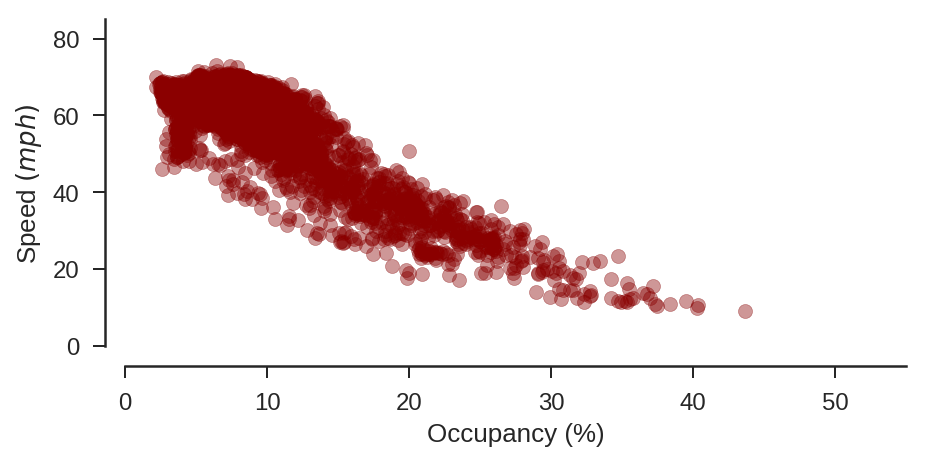

In [4]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
f, ax = plt.subplots(figsize=(7, 3))

ax.scatter(df.occupancy, df.Speed,c='#8B0000', alpha=0.12)
plt.xlim(0, 55)
plt.ylim(0, 85)

plt.ylabel("Speed $(mph)$", fontsize=13)
plt.xlabel("Occupancy (%)", fontsize=13)
sns.despine(offset=10)

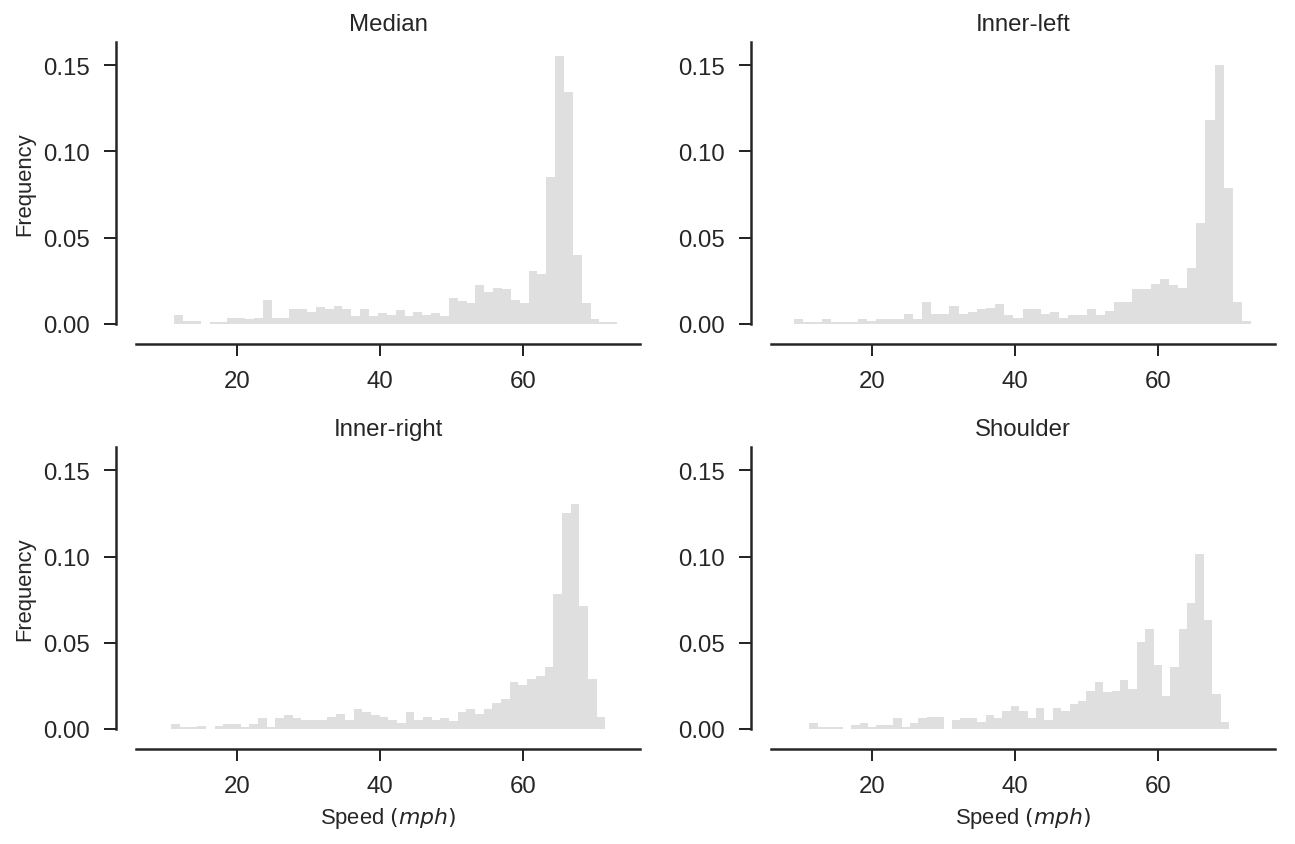

In [5]:
bins=50

g = sns.FacetGrid(data = df, col='Ilane_n', col_wrap=2, aspect=1.5, sharex=True, sharey=True)
g.map(plt.hist, 'Speed', color='grey', normed=True, bins=bins, alpha = 0.25)
sns.despine(offset=10)
#plt.xlim(0,50)

plt.tight_layout()

g.axes[0].set_ylabel('Frequency')
g.axes[2].set_ylabel('Frequency')
g.axes[2].set_xlabel('Speed $(mph)$')
g.axes[3].set_xlabel('Speed $(mph)$')
#g.set_titles("lane {col_name}")
labels = ['Median', 'Inner-left', 'Inner-right', 'Shoulder']
for ax,j in zip(g.axes.flatten(),labels):
    ax.set_title(j)

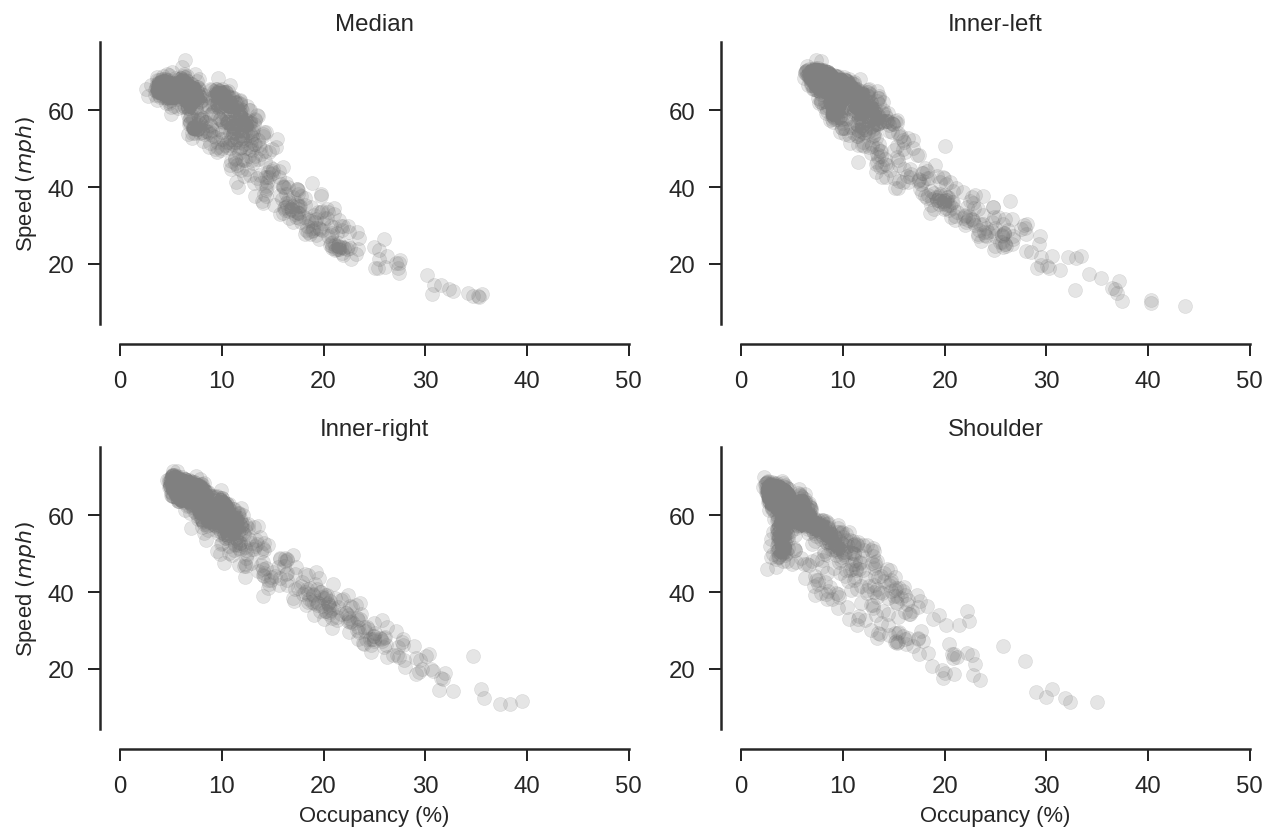

In [6]:
g = sns.FacetGrid(data = df, col='Ilane_n', col_wrap=2, aspect=1.5, sharex=True, sharey=True)
g.map(plt.scatter,'occupancy', 'Speed',color='grey', alpha = 0.05)
sns.despine(offset=10)
plt.xlim(0,50)
plt.tight_layout()
g.axes[3].set_xlabel('Occupancy (%)')
g.axes[2].set_xlabel('Occupancy (%)')
g.axes[0].set_ylabel('Speed $(mph)$')
g.axes[2].set_ylabel('Speed $(mph)$')
labels = ['Median', 'Inner-left', 'Inner-right', 'Shoulder']
for ax,j in zip(g.axes.flatten(),labels):
    ax.set_title(j)

In [7]:
df_11 = df
df_11["lane_n"]  = df_11["Ilane_n"].astype('category')
from patsy import dmatrices
_, Z   = dmatrices('Speed ~ -1+lane_n', data=df_11, return_type='matrix')
Z      = np.asarray(Z) # mixed effect
nrandm = np.shape(Z)

In [8]:
n_lane = len(df.Ilane_n.unique())
Lane_idx = df.Ilane_n.values

In [9]:
n_lane

4

In [10]:
X = df.occupancy
Y = df.Speed

In [11]:
# Number of iteration
niter = 1000
k = 2                                                    # Number of components 
n =  X.shape[0]                                          # Number of Sample size
with pm.Model() as Mixture_regression:
    
    # Proportion in each mixture
    π = pm.Dirichlet('π', np.array([1]*k), testval=np.ones(k)/k)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=Y.mean(), sd=100,shape=k) #Intercept
    β = pm.Normal('β', mu=0, sd=100, shape=k) 
    σ  = pm.HalfCauchy('σ', 5,shape=k)  #Noise
    
    # Classifying each observation
    category = pm.Categorical('category', p=π, shape=n)
    
    σr = pm.HalfCauchy('σr', 5)
    μr = pm.Normal('μr', mu=0, sd = σr, shape=n_lane)
    
    # Expected value 
    #Choose beta and alpha based on category
    μ = α[category] + β[category]*X + T.dot(Z,μr)

    # Likelihood 
    Y_obs = pm.Normal('Y_obs', mu=μ, sd=σ[category], observed=Y)
    
    step1 = pm.NUTS([π, α, β, σ, σr, μr]) #
    step2 = pm.ElemwiseCategorical([category], values=range(k))
    trace = pm.sample(niter, [step1, step2], njobs=4, progressbar=True)

100%|██████████| 1500/1500 [2:21:38<00:00,  1.18s/it] 


In [19]:
t1 = trace
pm.df_summary(t1,['π', 'α', 'β', 'σ', 'σr', 'μr']).round(4)

          mean      sd  mc_error  hpd_2.5  hpd_97.5
π__0    0.2429  0.0066    0.0005   0.2313    0.2573
π__1    0.7571  0.0066    0.0005   0.7427    0.7687
α__0   68.7851  0.1555    0.0153  68.5419   69.1065
α__1   74.6572  0.1079    0.0098  74.4824   74.8802
β__0   -0.9860  0.0149    0.0014  -1.0129   -0.9558
β__1   -2.0889  0.0067    0.0006  -2.1020   -2.0763
σ__0    0.9212  0.0229    0.0018   0.8822    0.9694
σ__1    4.5279  0.0329    0.0015   4.4711    4.5971
σr      6.0062  2.3652    0.0726   2.5222   10.4360
μr__0   2.1271  0.0976    0.0092   1.9433    2.3123
μr__1   7.7002  0.0849    0.0079   7.5211    7.8401
μr__2   4.6509  0.0876    0.0082   4.4691    4.7870
μr__3  -4.2417  0.0984    0.0090  -4.4374   -4.0584


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7b2d25e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc7b057f240>]], dtype=object)

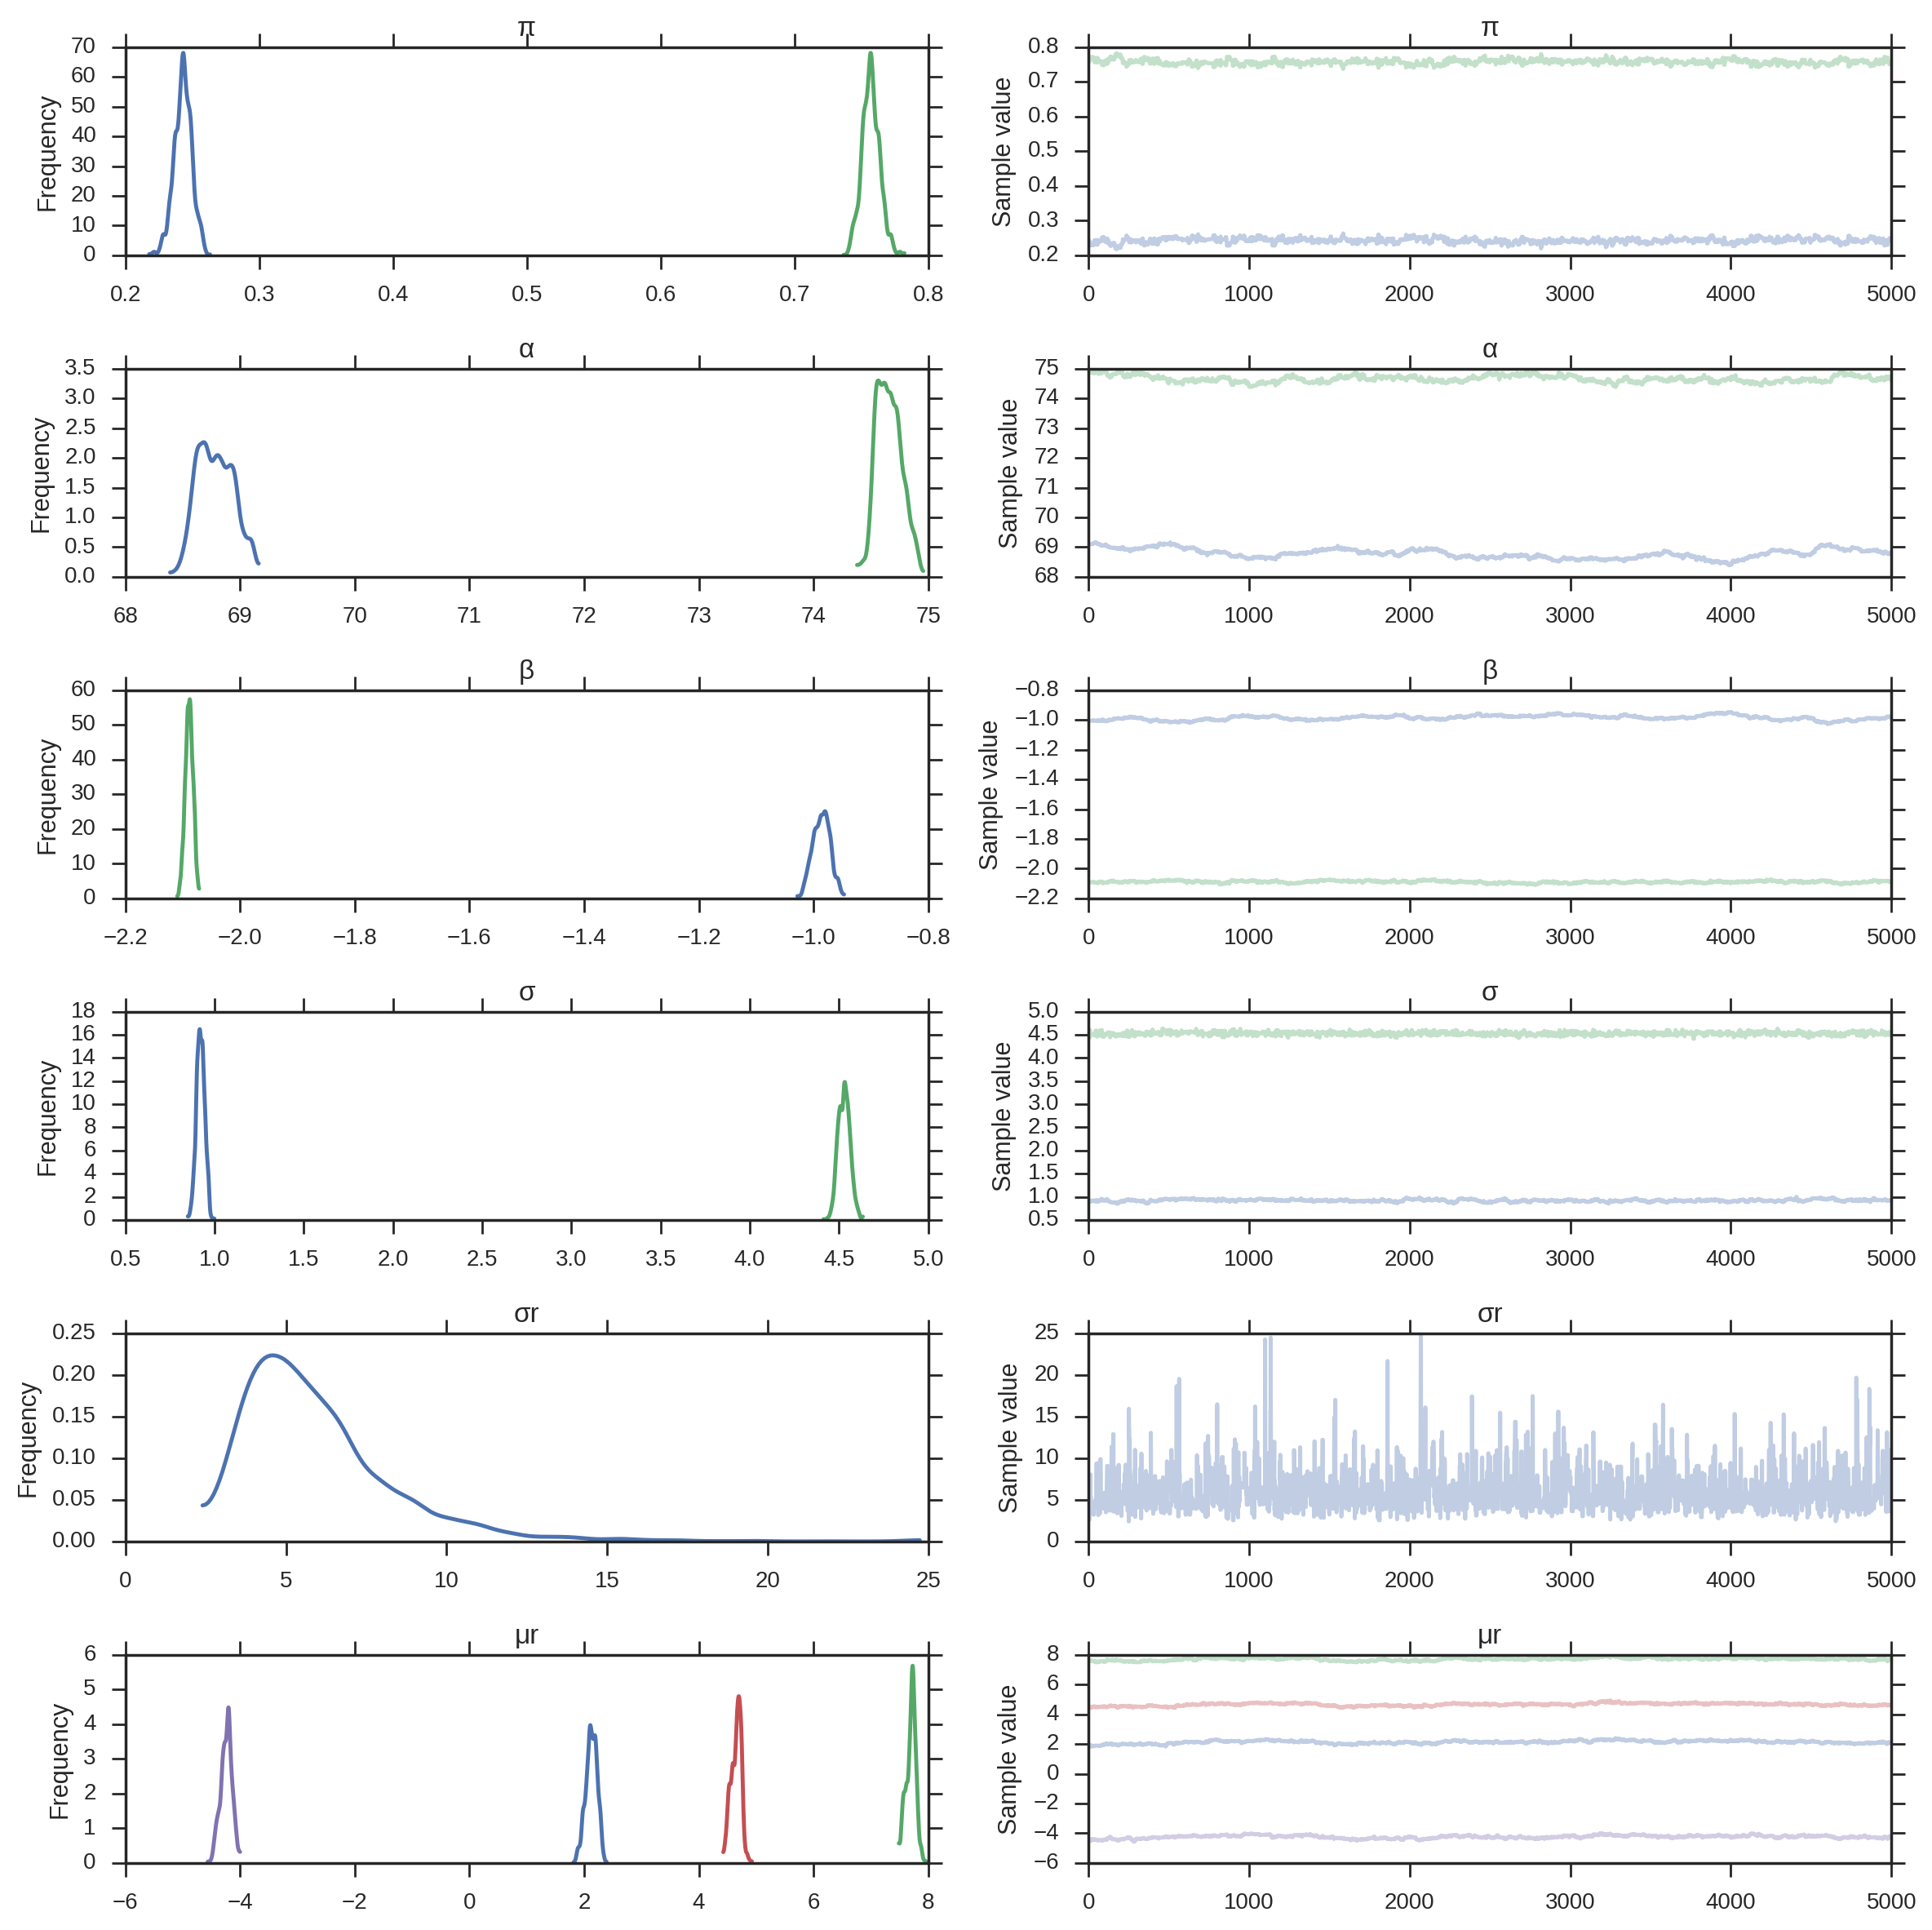

In [20]:
sns.set_context("notebook", font_scale= 1.0)
pm.traceplot(t1,['π', 'α', 'β', 'σ', 'σr', 'μr']);

In [21]:
# Creater posterior predictive samples
ppc = pm.sample_ppc(t1, model=Mixture_regression, samples=500)

100%|██████████| 500/500 [00:14<00:00, 33.93it/s]


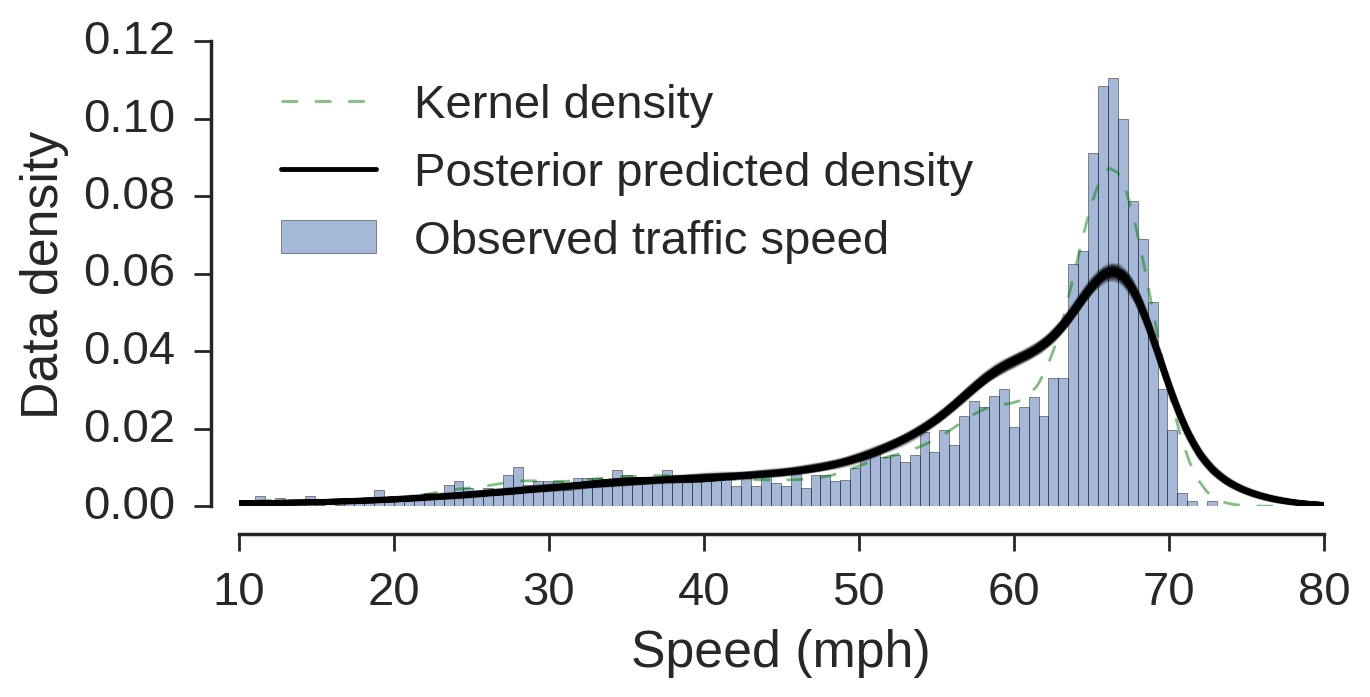

In [22]:
sns.set_context("notebook", font_scale= 1.7) 

fig, axes = plt.subplots(1,1, figsize=(7,3))
plt.hist(Y,100, normed=True,alpha=0.5)
sns.kdeplot(Y, alpha=0.5, lw=1, c='g',linestyle='dashed')
sns.kdeplot(ppc['Y_obs'][1], c='k',label = 'Posterior predicted density')
#sns.distplot(Y, kde=False)
for i in range(100):
    sns.kdeplot(ppc['Y_obs'][i], alpha=0.1, c='k')
plt.xlabel('Speed (mph)'), plt.ylabel('Data density')
plt.xlim(10,80)
plt.legend(['Kernel density',
            'Posterior predicted density'
            ,'Observed traffic speed'],
           loc='best')
sns.despine(offset=10)